# DS 3 Project - Data Generation and Clustering

In [1]:
import requests
import json
import pandas as pd

import base64
import billboard
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd

import time
import discogs_client
from time import sleep



## Fetch Billboard Greatest Artists chart

In [2]:
# Fetch the Billboard Greatest Artists chart
artist_greatest = billboard.ChartData('greatest-of-all-time-artists')

In [3]:
# Create a list to store artist data
artists_data = []

# Iterate through the chart entries and store the data
for artist_entry in artist_greatest:
    artists_data.append({
        'Rank': artist_entry.rank,
        'Artist': artist_entry.artist
    })

In [4]:
# Convert the list to a DataFrame
artists_df = pd.DataFrame(artists_data)

In [5]:
artists_df.head()

,Rank,Artist
0,1,The Beatles
1,2,The Rolling Stones
2,3,Elton John
3,4,Mariah Carey
4,5,Madonna


In [6]:
artists_df.shape

(125, 2)

## Discog Aunthetication 

In [10]:
# Authenticate with Discogs
d = discogs_client.Client('YourAppName/1.0', user_token="TOKEN_KEY")


In [11]:
def fetch_discogs_albums(artist_name):
    albums_list = []
    max_requests_per_minute = 60
    time_start = time.time()
    request_count = 0

    artist = d.search(artist_name, type='artist')[0]  # First search result
    current_page = 1
    more_pages = True

    while more_pages:
        try:
            albums = artist.releases.page(current_page)

            for album in albums:
                print(f"Processing album: {album.title}")
                albums_list.append({'Artist': artist_name, 'Album': album.title})
                request_count += 1

                # Throttle requests to avoid hitting rate limit
                if request_count >= max_requests_per_minute:
                    time_elapsed = time.time() - time_start
                    if time_elapsed < 60:
                        sleep_time = 60 - time_elapsed
                        print(f"Throttling: Sleeping for {sleep_time} seconds.")
                        time.sleep(sleep_time)
                        request_count = 0
                        time_start = time.time()

            # Check for more pages
            if hasattr(albums, 'pagination') and current_page < albums.pagination.pages:
                current_page += 1
            else:
                more_pages = False

        except discogs_client.exceptions.HTTPError as e:
            if e.status_code == 429:
                print(f"Rate limit reached for {artist_name}. Retrying after 10 seconds.")
                time.sleep(10)
            else:
                print(f"Error fetching data for {artist_name}: {e}")
                more_pages = False

    return albums_list


In [12]:
# DataFrame to store album information
albums_df = pd.DataFrame(columns=['Artist', 'Album'])

# Iterate over artists
for index, row in artists_df.iterrows():
    artist_name = row['Artist']
    print(f"Fetching albums for {artist_name}")

    artist_albums = fetch_discogs_albums(artist_name)
    albums_df = pd.concat([albums_df, pd.DataFrame(artist_albums)], ignore_index=True)



Fetching albums for The Beatles
Processing album: Hello Little Girl / Till There Was You
Processing album: My Bonnie
Processing album: Love Me Do
Processing album: Please Please Me 
Processing album: Boys / Love Me Do
Processing album: Please Mr Postman  
Processing album: Till There Was You
Processing album: Please Please Me  
Processing album: What Goes On
Processing album: P.S. I Love You 
Processing album: Please Please me
Processing album: From Me To You
Processing album: Roll Over Beethoven
Processing album: My Bonnie / Ya Ya
Processing album: All My Loving / Love Me Do
Processing album: Love Me Do / Please Please Me
Processing album: She Loves You
Processing album: Ella Te Ama / Quiero Estrechar Tu Mano / La Vi Alla / Seras Mia
Processing album: Roll Over Beethoven
Processing album: I Saw Her Standing There 
Processing album: Meet The Beatles!
Processing album: Abrazame Fuertes / No Otra Vez
Processing album: The Beatles
Processing album: I Want To Hold Your Hand
Processing albu

In [13]:
# Output the results
albums_df.head()
print(f"Total albums fetched: {len(albums_df)}")

Total albums fetched: 6246


In [14]:
albums_df.head()

,Artist,Album
0,The Beatles,Hello Little Girl / Till There Was You
1,The Beatles,My Bonnie
2,The Beatles,Love Me Do
3,The Beatles,Please Please Me
4,The Beatles,Boys / Love Me Do


In [15]:
# Save the DataFrame to a CSV file
albums_df.to_csv('artist_albums.csv', index=False)


# READ THE Fetched Album From Discogg

In [7]:
# Read the DataFrame from the CSV file
albums_df = pd.read_csv('artist_albums.csv')

In [8]:
albums_df.shape

(6246, 2)

# SPOTIFY TO GET ALBUMS DETAILS

In [9]:
# Authenticate with Spotify
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="CLIENT_KEY", client_secret="SECRET_KEY"))


# GET Albums Popularity from Spotify

In [10]:
def fetch_album_popularity(sp, artist_name, album_name, retry_after=30):
    try:
        results = sp.search(q='album:' + album_name + ' artist:' + artist_name, type='album', limit=1)
        albums = results['albums']['items']
        if albums and 'popularity' in albums[0]:
            return albums[0]['popularity']
        else:
            return None
    except spotipy.exceptions.SpotifyException as e:
        if e.http_status == 429:
            print(f"Rate limit hit, pausing for {retry_after} seconds.")
            time.sleep(retry_after)
            return fetch_album_popularity(sp, artist_name, album_name, retry_after)
        else:
            print(f"Error fetching popularity for {artist_name} - {album_name}: {e}")
            return None

In [11]:
def update_album_popularity(df, start_index=0):
    total_albums = len(df)
    for index, row in df.iloc[start_index:].iterrows():
        # Print the current progress
        print(f"Processing album {index + 1}/{total_albums}: {row['Artist']} - {row['Album']}")

        popularity = fetch_album_popularity(sp, row['Artist'], row['Album'])
        df.at[index, 'Popularity'] = popularity

        # Throttle requests to avoid hitting rate limits
        time.sleep(0.5)

# Start the update process
update_album_popularity(albums_df)

Processing album 1/6246: The Beatles - Hello Little Girl / Till There Was You
Processing album 2/6246: The Beatles - My Bonnie
Processing album 3/6246: The Beatles - Love Me Do
Processing album 4/6246: The Beatles - Please Please Me 
Processing album 5/6246: The Beatles - Boys / Love Me Do
Processing album 6/6246: The Beatles - Please Mr Postman  
Processing album 7/6246: The Beatles - Till There Was You
Processing album 8/6246: The Beatles - Please Please Me  
Processing album 9/6246: The Beatles - What Goes On
Processing album 10/6246: The Beatles - P.S. I Love You 
Processing album 11/6246: The Beatles - Please Please me
Processing album 12/6246: The Beatles - From Me To You
Processing album 13/6246: The Beatles - Roll Over Beethoven
Processing album 14/6246: The Beatles - My Bonnie / Ya Ya
Processing album 15/6246: The Beatles - All My Loving / Love Me Do
Processing album 16/6246: The Beatles - Love Me Do / Please Please Me
Processing album 17/6246: The Beatles - She Loves You
Proc

In [12]:
# Display the shape of the DataFrame
print("Shape of the DataFrame:", albums_df.shape)

Shape of the DataFrame: (6246, 3)


In [13]:
# Display the first 5 rows of the DataFrame
print("First 5 rows of the DataFrame:")
albums_df.head()

First 5 rows of the DataFrame:


,Artist,Album,Popularity
0,The Beatles,Hello Little Girl / Till There Was You,NaN
1,The Beatles,My Bonnie,NaN
2,The Beatles,Love Me Do,NaN
3,The Beatles,Please Please Me,NaN
4,The Beatles,Boys / Love Me Do,NaN


## Check for Duplicates:

In [14]:
duplicates = albums_df.duplicated()
print("Number of duplicate rows:", duplicates.sum())


Number of duplicate rows: 558


In [15]:
#Calculate the Percentage of Duplicates:
total_rows = albums_df.shape[0]
duplicate_percentage = (duplicates.sum() / total_rows) * 100
print("Percentage of duplicates:", duplicate_percentage)


Percentage of duplicates: 8.93371757925072


In [16]:
#Remove Duplicates:

albums_df_clean = albums_df.drop_duplicates()
print("Shape after removing duplicates:", albums_df_clean.shape)


Shape after removing duplicates: (5688, 3)


In [45]:
albums_df_clean.shape

(5688, 3)

In [46]:
# Save the DataFrame to a CSV file
albums_df_clean.to_csv('artist_albums_popularity_all.csv', index=False)


## Fetch Album Details from Discogs:

In [55]:
# Read the DataFrame from the CSV file
albums_df_clean = pd.read_csv('artist_albums_popularity_all.csv')

In [56]:
# Authenticate with Discogs
discogs_client_instance = discogs_client.Client('YourAppName/1.0', user_token="TOKEN_KEY")


In [66]:
def fetch_album_tracklist(discogs_client_instance, artist_name, album_title):
    retry_wait = 60  # Default wait time in seconds
    max_retries = 5  # Maximum number of retries
    attempts = 0

    while attempts < max_retries:
        try:
            results = discogs_client_instance.search(artist_name + ' ' + album_title, type='release')
            if len(results) > 0:
                release = results[0]  # Assuming the first result is the correct one
                return [track.title for track in release.tracklist]
            else:
                return []
        except discogs_client.exceptions.HTTPError as e:
            if e.status_code == 429:
                print(f"Rate limit hit, pausing for {retry_wait} seconds.")
                time.sleep(retry_wait)
                attempts += 1
            else:
                print(f"Error fetching tracklist for {album_title}: {e}")
                break
    return []


In [67]:
# Process only the first 5 rows of the DataFrame
for index, row in albums_df_clean.head(5).iterrows():
    artist = row['Artist']
    album = row['Album']
    album_key = f"{artist} - {album}"

    # Progress tracking
    print(f"Processing album {index + 1}/5: {album_key}")

    # Fetch the tracklist
    tracklist = fetch_album_tracklist(discogs_client_instance, artist, album)
    album_tracklists[album_key] = tracklist

    # Throttle requests to stay within rate limits
    time.sleep(delay_between_requests)

# Print the results for the first 5 albums
for album_key, tracks in album_tracklists.items():
    print(f"Album: {album_key}")
    print("Tracks:", tracks)
    print()


Processing album 1/5: The Beatles - Hello Little Girl / Till There Was You
Processing album 2/5: The Beatles - My Bonnie
Processing album 3/5: The Beatles - Love Me Do
Processing album 4/5: The Beatles - Please Please Me 
Processing album 5/5: The Beatles - Boys / Love Me Do
Album: The Beatles - Hello Little Girl / Till There Was You
Tracks: ['Hello Little Girl', 'Till There Was You']

Album: The Beatles - My Bonnie
Tracks: ['My Bonnie (My Bonnie Lies Over The Ocean)', 'The Saints (When The Saints Go Marching In)']

Album: The Beatles - Love Me Do
Tracks: ['The Beatles', 'Back In The U.S.S.R.', 'Dear Prudence', 'Glass Onion', 'Ob-La-Di, Ob-La-Da', 'Wild Honey Pie', 'The Continuing Story Of Bungalow Bill', 'While My Guitar Gently Weeps', 'Happiness Is A Warm Gun', 'Martha My Dear', "I'm So Tired", 'Blackbird', 'Piggies', 'Rocky Raccoon', "Don't Pass Me By", "Why Don't We Do It In The Road?", 'I Will', 'Julia', 'Birthday', 'Yer Blues', "Mother Nature's Son", "Everybody's Got Something To

In [68]:
# Prepare a list to store album and track information
album_tracks_data = []

# Iterate over the album_tracklists dictionary
for album_key, tracks in album_tracklists.items():
    artist, album = album_key.split(" - ", 1)  # Splitting the key to get artist and album names
    for track in tracks:
        album_tracks_data.append({"Artist": artist, "Album": album, "Track": track})

# Convert the list to a DataFrame
tracks_df = pd.DataFrame(album_tracks_data)

# Display the first few rows of the DataFrame
print(tracks_df.head())

# Check the shape of the DataFrame
print("Shape of the DataFrame:", tracks_df.shape)

        Artist                                   Album  \
0  The Beatles  Hello Little Girl / Till There Was You   
1  The Beatles  Hello Little Girl / Till There Was You   
2  The Beatles                               My Bonnie   
3  The Beatles                               My Bonnie   
4  The Beatles                              Love Me Do   

                                         Track  
0                            Hello Little Girl  
1                           Till There Was You  
2    My Bonnie (My Bonnie Lies Over The Ocean)  
3  The Saints (When The Saints Go Marching In)  
4                                  The Beatles  
Shape of the DataFrame: (587, 3)


## Fulll dataset

In [69]:
# Initialize a dictionary to store album tracklists
album_tracklists = {}

# Throttle setup
requests_per_minute = 60
delay_between_requests = 60 / requests_per_minute

# Iterate through the entire albums DataFrame
total_albums = len(albums_df_clean)
for index, row in albums_df_clean.iterrows():
    artist = row['Artist']
    album = row['Album']
    album_key = f"{artist} - {album}"

    # Progress tracking
    print(f"Processing album {index + 1}/{total_albums}: {album_key}")

    # Fetch the tracklist
    tracklist = fetch_album_tracklist(discogs_client_instance, artist, album)
    album_tracklists[album_key] = tracklist

    # Throttle requests to stay within rate limits
    time.sleep(delay_between_requests)

print("Completed fetching tracklists for all albums.")

Processing album 1/5688: The Beatles - Hello Little Girl / Till There Was You
Processing album 2/5688: The Beatles - My Bonnie
Processing album 3/5688: The Beatles - Love Me Do
Processing album 4/5688: The Beatles - Please Please Me 
Processing album 5/5688: The Beatles - Boys / Love Me Do
Processing album 6/5688: The Beatles - Please Mr Postman  
Processing album 7/5688: The Beatles - Till There Was You
Processing album 8/5688: The Beatles - Please Please Me  
Processing album 9/5688: The Beatles - What Goes On
Processing album 10/5688: The Beatles - P.S. I Love You 
Processing album 11/5688: The Beatles - Please Please me
Processing album 12/5688: The Beatles - From Me To You
Processing album 13/5688: The Beatles - Roll Over Beethoven
Processing album 14/5688: The Beatles - My Bonnie / Ya Ya
Processing album 15/5688: The Beatles - All My Loving / Love Me Do
Processing album 16/5688: The Beatles - Love Me Do / Please Please Me
Processing album 17/5688: The Beatles - She Loves You
Proc

In [70]:
# Prepare a list to store album and track information
album_tracks_data = []

# Iterate over the album_tracklists dictionary
for album_key, tracks in album_tracklists.items():
    artist, album = album_key.split(" - ", 1)
    for track in tracks:
        album_tracks_data.append({"Artist": artist, "Album": album, "Track": track})

# Convert the list to a DataFrame
tracks_df = pd.DataFrame(album_tracks_data)


In [71]:
tracks_df.head()

,Artist,Album,Track
0,The Beatles,Hello Little Girl / Till There Was You,Hello Little Girl
1,The Beatles,Hello Little Girl / Till There Was You,Till There Was You
2,The Beatles,My Bonnie,My Bonnie (My Bonnie Lies Over The Ocean)
3,The Beatles,My Bonnie,The Saints (When The Saints Go Marching In)
4,The Beatles,Love Me Do,The Beatles


In [73]:
tracks_df.shape

(56089, 3)

In [82]:
# Filter the first 10 records from the DataFrame
subset_tracks_df = tracks_df.head(100)
print(subset_tracks_df)

# Create a copy of the subset to avoid the SettingWithCopyWarning
subset_tracks_df = tracks_df.head(100).copy()

         Artist                                   Album  \
0   The Beatles  Hello Little Girl / Till There Was You   
1   The Beatles  Hello Little Girl / Till There Was You   
2   The Beatles                               My Bonnie   
3   The Beatles                               My Bonnie   
4   The Beatles                              Love Me Do   
..          ...                                     ...   
95  The Beatles                              Love Me Do   
96  The Beatles                              Love Me Do   
97  The Beatles                              Love Me Do   
98  The Beatles                              Love Me Do   
99  The Beatles                              Love Me Do   

                                             Track  
0                                Hello Little Girl  
1                               Till There Was You  
2        My Bonnie (My Bonnie Lies Over The Ocean)  
3      The Saints (When The Saints Go Marching In)  
4                         

In [88]:
def fetch_track_popularity(sp, artist_name, track_name):
    try:
        # Search for the track on Spotify
        results = sp.search(q='artist:' + artist_name + ' track:' + track_name, type='track', limit=1)
        tracks = results['tracks']['items']
        if tracks:
            # Return the popularity score of the first search result
            return tracks[0]['popularity']
        else:
            return None
    except spotipy.exceptions.SpotifyException as e:
        if e.http_status == 429:
            # Handle rate limit
            retry_after = int(e.headers.get('Retry-After', 10))
            print(f"Rate limit hit, pausing for {retry_after} seconds.")
            time.sleep(retry_after)
            return fetch_track_popularity(sp, artist_name, track_name)
        else:
            print(f"Error fetching popularity for {artist_name} - {track_name}: {e}")
            return None

In [84]:
# Add a new column for popularity scores in the subset
subset_tracks_df['Popularity'] = subset_tracks_df.apply(lambda row: fetch_track_popularity(sp, row['Artist'], row['Track']), axis=1)


In [85]:
subset_tracks_df.head()

,Artist,Album,Track,Popularity
0,The Beatles,Hello Little Girl / Till There Was You,Hello Little Girl,34.0
1,The Beatles,Hello Little Girl / Till There Was You,Till There Was You,64.0
2,The Beatles,My Bonnie,My Bonnie (My Bonnie Lies Over The Ocean),0.0
3,The Beatles,My Bonnie,The Saints (When The Saints Go Marching In),NaN
4,The Beatles,Love Me Do,The Beatles,86.0


In [87]:
subset_tracks_df.tail()

,Artist,Album,Track,Popularity
95,The Beatles,Love Me Do,Step Inside Love (Studio Jam),26.0
96,The Beatles,Love Me Do,Los Paranoias (Studio Jam),27.0
97,The Beatles,Love Me Do,Can You Take Me Back? (Take 1),30.0
98,The Beatles,Love Me Do,Birthday (Take 2 - Instrumental Backing Track),25.0
99,The Beatles,Love Me Do,Piggies (Take 12 - Instrumental Backing Track),23.0


## Full data Popularity

In [ ]:
# Add a new column for popularity scores in the full DataFrame
progress = 0
total_tracks = len(tracks_df)

for index, row in tracks_df.iterrows():
    # Print progress
    progress += 1
    if progress % 100 == 0:  # Update progress every 100 tracks
        print(f"Processed {progress} of {total_tracks} tracks.")

    # Fetch popularity
    popularity = fetch_track_popularity(sp, row['Artist'], row['Track'])
    tracks_df.at[index, 'Popularity'] = popularity


In [110]:
# Check the first few rows of the updated DataFrame
tracks_df.head()

,Artist,Album,Track,Popularity
0,The Beatles,Hello Little Girl / Till There Was You,Hello Little Girl,34.0
1,The Beatles,Hello Little Girl / Till There Was You,Till There Was You,64.0
2,The Beatles,My Bonnie,My Bonnie (My Bonnie Lies Over The Ocean),0.0
3,The Beatles,My Bonnie,The Saints (When The Saints Go Marching In),NaN
4,The Beatles,Love Me Do,The Beatles,86.0


# Create the Reduced Dataset:

In [124]:


# Subset with existing popularity scores
popularity_scored_subset = tracks_df.dropna(subset=['Popularity'])

# Subset without popularity scores
nan_popularity_subset = tracks_df[tracks_df['Popularity'].isna()]

# Sort the NaN subset by artist and album, and group
grouped = nan_popularity_subset.groupby(['Artist', 'Album'])

# Select the top 5 songs from each album of each artist
top_7_songs_per_album = grouped.head(7)

# Concatenate the two subsets
reduced_df = pd.concat([popularity_scored_subset, top_7_songs_per_album])

# Drop duplicates that might have occurred during concatenation
reduced_df.drop_duplicates(inplace=True)

# Check the shape of the new dataset
print("Shape of the reduced dataset:", reduced_df.shape)

# Print the first few rows of the reduced dataset for a quick inspection
print(reduced_df.head())


Shape of the reduced dataset: (32725, 4)
        Artist                                   Album  \
0  The Beatles  Hello Little Girl / Till There Was You   
1  The Beatles  Hello Little Girl / Till There Was You   
2  The Beatles                               My Bonnie   
4  The Beatles                              Love Me Do   
5  The Beatles                              Love Me Do   

                                       Track  Popularity  
0                          Hello Little Girl        34.0  
1                         Till There Was You        64.0  
2  My Bonnie (My Bonnie Lies Over The Ocean)         0.0  
4                                The Beatles        86.0  
5                       Back In The U.S.S.R.        64.0  


In [125]:
reduced_df.to_csv("reduced_df.csv",index=False)

In [126]:
tracks_df.to_csv("tracks_df.csv",index=False)

# GET NEW MERGED DATA

In [127]:
# Read the Excel file into a DataFrame
new_df = pd.read_excel('tracks_df_merged_final.xlsx')

In [128]:
new_df.head()

,Artist,Track
0,2 Chainz,I'm Different
1,21 Savage,A Lot
2,21 Savage,Bank Account
3,24kGoldn Featuring iann dior,Mood
4,5 Seconds Of Summer,Amnesia


In [129]:
# Authentication
sp_api = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="KEY", client_secret="KEY"))


In [130]:
def get_spotify_track_id(artist, track):
    """Search for a track on Spotify and return its Spotify ID."""
    query = f'artist:{artist} track:{track}'
    result = sp_api.search(q=query, type='track', limit=1)
    items = result['tracks']['items']
    if items:
        return items[0]['id']
    else:
        return None

In [131]:
def get_audio_features(track_id):
    """Get audio features for a given Spotify track ID."""
    if track_id:
        return sp_api.audio_features(track_id)[0]
    else:
        return None

In [132]:
# Adding a new column for Spotify Track ID
new_df['Spotify_ID'] = new_df.apply(lambda row: get_spotify_track_id(row['Artist'], row['Track']), axis=1)

# Fetching audio features
new_df['Audio_Features'] = new_df['Spotify_ID'].apply(get_audio_features)

# Inspect the first few rows
print(new_df.head())

                         Artist          Track              Spotify_ID  \
0                      2 Chainz  I'm Different                    None   
1                     21 Savage          A Lot  2t8yVaLvJ0RenpXUIAC52d   
2                     21 Savage   Bank Account  5eqK0tbzUPo2SoeZsov04s   
3  24kGoldn Featuring iann dior           Mood                    None   
4           5 Seconds Of Summer        Amnesia  1JCCdiru7fhstOIF4N7WJC   

                                      Audio_Features  
0                                               None  
1  {'danceability': 0.837, 'energy': 0.636, 'key'...  
2  {'danceability': 0.884, 'energy': 0.347, 'key'...  
3                                               None  
4  {'danceability': 0.572, 'energy': 0.499, 'key'...  


In [133]:
new_df.head()

,Artist,Track,Spotify_ID,Audio_Features
0,2 Chainz,I'm Different,None,None
1,21 Savage,A Lot,2t8yVaLvJ0RenpXUIAC52d,"{'danceability': 0.837, 'energy': 0.636, 'key'..."
2,21 Savage,Bank Account,5eqK0tbzUPo2SoeZsov04s,"{'danceability': 0.884, 'energy': 0.347, 'key'..."
3,24kGoldn Featuring iann dior,Mood,None,None
4,5 Seconds Of Summer,Amnesia,1JCCdiru7fhstOIF4N7WJC,"{'danceability': 0.572, 'energy': 0.499, 'key'..."


In [134]:
# Counting the number of None values in the 'Spotify_ID' column
none_spotify_id_count = new_df['Spotify_ID'].isna().sum()
print(f"Number of tracks with None Spotify ID: {none_spotify_id_count}")

# Counting the number of None values in the 'Audio_Features' column
none_audio_features_count = new_df['Audio_Features'].isna().sum()
print(f"Number of tracks with None Audio Features: {none_audio_features_count}")


Number of tracks with None Spotify ID: 1017
Number of tracks with None Audio Features: 1017


In [135]:
new_df.shape


(2345, 4)

In [137]:
new_df.tail(10)

,Artist,Track,Spotify_ID,Audio_Features
2335,Zach Bryan,Something In The Orange,3WMj8moIAXJhHsyLaqIIHI,"{'danceability': 0.369, 'energy': 0.192, 'key'..."
2336,Zach Bryan Featuring Kacey Musgraves,I Remember Everything,None,None
2337,Zara Larsson & MNEK,Never Forget You,None,None
2338,Zay Hilfigerrr & Zayion McCall,Juju On That Beat (TZ Anthem),6VQ1iGUwAyFugBI73h1iqs,"{'danceability': 0.808, 'energy': 0.919, 'key'..."
2339,Zayn,Pillowtalk,0PDUDa38GO8lMxLCRc4lL1,"{'danceability': 0.584, 'energy': 0.7, 'key': ..."
2340,Zayn / Taylor Swift,I Don't Wanna Live Forever (Fifty Shades Darker),None,None
2341,Zedd & Alessia Cara,Stay,6uBhi9gBXWjanegOb2Phh0,"{'danceability': 0.69, 'energy': 0.622, 'key':..."
2342,Zedd Featuring Foxes,Clarity,None,None
2343,Zedd Featuring Hayley Williams,Stay The Night,2QtJA4gbwe1AcanB2p21aP,"{'danceability': 0.596, 'energy': 0.738, 'key'..."
2344,"Zedd, Maren Morris & Grey",The Middle,09IStsImFySgyp0pIQdqAc,"{'danceability': 0.753, 'energy': 0.657, 'key'..."


# FEATURE 

In [142]:
# Filter to create a subset with available audio features
features_available_df = new_df.dropna(subset=['Audio_Features'])

# Expanding the audio features into separate columns
expanded_features = pd.DataFrame(features_available_df['Audio_Features'].tolist(), index=features_available_df.index)

# Join the expanded features with the original DataFrame
features_available_df = features_available_df.join(expanded_features)

# Drop the original 'Audio_Features' column as it's no longer needed
features_available_df.drop(columns=['Audio_Features'], inplace=True)

# Check the first few rows of the new DataFrame
features_available_df.head()

# Optionally, check the shape of the new DataFrame
print("Shape of the DataFrame with audio features:", features_available_df.shape)


Shape of the DataFrame with audio features: (1328, 21)


In [143]:
features_available_df.head()

,Artist,Track,Spotify_ID,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
1,21 Savage,A Lot,2t8yVaLvJ0RenpXUIAC52d,0.837,0.636,1,-7.643,1,0.0860,0.039500,...,0.3420,0.274,145.972,audio_features,2t8yVaLvJ0RenpXUIAC52d,spotify:track:2t8yVaLvJ0RenpXUIAC52d,https://api.spotify.com/v1/tracks/2t8yVaLvJ0Re...,https://api.spotify.com/v1/audio-analysis/2t8y...,288624,4
2,21 Savage,Bank Account,5eqK0tbzUPo2SoeZsov04s,0.884,0.347,8,-8.227,0,0.3500,0.015000,...,0.0871,0.376,75.016,audio_features,5eqK0tbzUPo2SoeZsov04s,spotify:track:5eqK0tbzUPo2SoeZsov04s,https://api.spotify.com/v1/tracks/5eqK0tbzUPo2...,https://api.spotify.com/v1/audio-analysis/5eqK...,220307,4
4,5 Seconds Of Summer,Amnesia,1JCCdiru7fhstOIF4N7WJC,0.572,0.499,2,-5.237,1,0.0311,0.028300,...,0.2130,0.108,101.593,audio_features,1JCCdiru7fhstOIF4N7WJC,spotify:track:1JCCdiru7fhstOIF4N7WJC,https://api.spotify.com/v1/tracks/1JCCdiru7fhs...,https://api.spotify.com/v1/audio-analysis/1JCC...,237248,4
5,5 Seconds Of Summer,She Looks So Perfect,1gugDOSMREb34Xo0c1PlxM,0.494,0.951,9,-4.237,1,0.1320,0.000569,...,0.3270,0.441,160.025,audio_features,1gugDOSMREb34Xo0c1PlxM,spotify:track:1gugDOSMREb34Xo0c1PlxM,https://api.spotify.com/v1/tracks/1gugDOSMREb3...,https://api.spotify.com/v1/audio-analysis/1gug...,202496,4
6,5 Seconds Of Summer,Youngblood,2iUXsYOEPhVqEBwsqP70rE,0.596,0.854,7,-5.114,0,0.4630,0.016900,...,0.1240,0.152,120.274,audio_features,2iUXsYOEPhVqEBwsqP70rE,spotify:track:2iUXsYOEPhVqEBwsqP70rE,https://api.spotify.com/v1/tracks/2iUXsYOEPhVq...,https://api.spotify.com/v1/audio-analysis/2iUX...,203418,4


In [144]:
features_available_df.to_csv("features_available_df.csv")


# READ THE UPDATED DATASET WITH ALL FEATURES

In [2]:
features_available_df = pd.read_csv("features_available_df.csv")

In [3]:
features_available_df.head()

,Unnamed: 0,Artist,Track,Spotify_ID,danceability,energy,key,loudness,mode,speechiness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,1,21 Savage,A Lot,2t8yVaLvJ0RenpXUIAC52d,0.837,0.636,1,-7.643,1,0.0860,...,0.3420,0.274,145.972,audio_features,2t8yVaLvJ0RenpXUIAC52d,spotify:track:2t8yVaLvJ0RenpXUIAC52d,https://api.spotify.com/v1/tracks/2t8yVaLvJ0Re...,https://api.spotify.com/v1/audio-analysis/2t8y...,288624,4
1,2,21 Savage,Bank Account,5eqK0tbzUPo2SoeZsov04s,0.884,0.347,8,-8.227,0,0.3500,...,0.0871,0.376,75.016,audio_features,5eqK0tbzUPo2SoeZsov04s,spotify:track:5eqK0tbzUPo2SoeZsov04s,https://api.spotify.com/v1/tracks/5eqK0tbzUPo2...,https://api.spotify.com/v1/audio-analysis/5eqK...,220307,4
2,4,5 Seconds Of Summer,Amnesia,1JCCdiru7fhstOIF4N7WJC,0.572,0.499,2,-5.237,1,0.0311,...,0.2130,0.108,101.593,audio_features,1JCCdiru7fhstOIF4N7WJC,spotify:track:1JCCdiru7fhstOIF4N7WJC,https://api.spotify.com/v1/tracks/1JCCdiru7fhs...,https://api.spotify.com/v1/audio-analysis/1JCC...,237248,4
3,5,5 Seconds Of Summer,She Looks So Perfect,1gugDOSMREb34Xo0c1PlxM,0.494,0.951,9,-4.237,1,0.1320,...,0.3270,0.441,160.025,audio_features,1gugDOSMREb34Xo0c1PlxM,spotify:track:1gugDOSMREb34Xo0c1PlxM,https://api.spotify.com/v1/tracks/1gugDOSMREb3...,https://api.spotify.com/v1/audio-analysis/1gug...,202496,4
4,6,5 Seconds Of Summer,Youngblood,2iUXsYOEPhVqEBwsqP70rE,0.596,0.854,7,-5.114,0,0.4630,...,0.1240,0.152,120.274,audio_features,2iUXsYOEPhVqEBwsqP70rE,spotify:track:2iUXsYOEPhVqEBwsqP70rE,https://api.spotify.com/v1/tracks/2iUXsYOEPhVq...,https://api.spotify.com/v1/audio-analysis/2iUX...,203418,4


# Retrieve Genres

In [149]:
def get_artist_genres(artist_name):
    """Search for an artist on Spotify and return their genres."""
    results = sp_api.search(q=f'artist:{artist_name}', type='artist', limit=1)
    items = results['artists']['items']
    if items:
        return items[0]['genres']
    else:
        return None


In [150]:
# Adding a new column for Artist Genres
features_available_df['Artist_Genres'] = features_available_df['Artist'].apply(get_artist_genres)


In [152]:
# Inspect the first few rows with the new genres column
features_available_df.head(5)


,Artist,Track,Spotify_ID,danceability,energy,key,loudness,mode,speechiness,acousticness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,Artist_Genres
1,21 Savage,A Lot,2t8yVaLvJ0RenpXUIAC52d,0.837,0.636,1,-7.643,1,0.0860,0.039500,...,0.274,145.972,audio_features,2t8yVaLvJ0RenpXUIAC52d,spotify:track:2t8yVaLvJ0RenpXUIAC52d,https://api.spotify.com/v1/tracks/2t8yVaLvJ0Re...,https://api.spotify.com/v1/audio-analysis/2t8y...,288624,4,"[atl hip hop, hip hop, rap]"
2,21 Savage,Bank Account,5eqK0tbzUPo2SoeZsov04s,0.884,0.347,8,-8.227,0,0.3500,0.015000,...,0.376,75.016,audio_features,5eqK0tbzUPo2SoeZsov04s,spotify:track:5eqK0tbzUPo2SoeZsov04s,https://api.spotify.com/v1/tracks/5eqK0tbzUPo2...,https://api.spotify.com/v1/audio-analysis/5eqK...,220307,4,"[atl hip hop, hip hop, rap]"
4,5 Seconds Of Summer,Amnesia,1JCCdiru7fhstOIF4N7WJC,0.572,0.499,2,-5.237,1,0.0311,0.028300,...,0.108,101.593,audio_features,1JCCdiru7fhstOIF4N7WJC,spotify:track:1JCCdiru7fhstOIF4N7WJC,https://api.spotify.com/v1/tracks/1JCCdiru7fhs...,https://api.spotify.com/v1/audio-analysis/1JCC...,237248,4,"[boy band, pop]"
5,5 Seconds Of Summer,She Looks So Perfect,1gugDOSMREb34Xo0c1PlxM,0.494,0.951,9,-4.237,1,0.1320,0.000569,...,0.441,160.025,audio_features,1gugDOSMREb34Xo0c1PlxM,spotify:track:1gugDOSMREb34Xo0c1PlxM,https://api.spotify.com/v1/tracks/1gugDOSMREb3...,https://api.spotify.com/v1/audio-analysis/1gug...,202496,4,"[boy band, pop]"
6,5 Seconds Of Summer,Youngblood,2iUXsYOEPhVqEBwsqP70rE,0.596,0.854,7,-5.114,0,0.4630,0.016900,...,0.152,120.274,audio_features,2iUXsYOEPhVqEBwsqP70rE,spotify:track:2iUXsYOEPhVqEBwsqP70rE,https://api.spotify.com/v1/tracks/2iUXsYOEPhVq...,https://api.spotify.com/v1/audio-analysis/2iUX...,203418,4,"[boy band, pop]"


# Using Discogg to get Genre

In [170]:
#pip install discogs_client

In [26]:
import discogs_client
import pandas as pd
import time

disco_api = discogs_client.Client('YourUserAgent/1.0', user_token='KEY')


In [17]:
def get_album_name(artist, track):
    try:
        results = disco_api.search(artist=artist, track=track, type='release')
        if results:
            # Assuming the first result is the most relevant
            return results[0].title  # This should return the album name
        else:
            return None
    except Exception as e:
        print(f"Error: {e}")
        return None


In [18]:
# Initialize 'Album_Name' column as type 'object' to hold strings
features_available_df['Album_Name'] = pd.NA
features_available_df['Album_Name'] = features_available_df['Album_Name'].astype('object')

request_count = 0
max_requests_per_minute = 40  # Adjust based on your rate limit
pause_duration = 70  # Increased pause duration

for index, row in features_available_df.iterrows():
    if request_count >= max_requests_per_minute:
        print("Pausing to respect rate limits...")
        time.sleep(pause_duration)  # Sleep to reset the rate limit window
        request_count = 0  # Reset the request count

    album_name = get_album_name(row['Artist'], row['Track'])
    features_available_df.at[index, 'Album_Name'] = album_name
    request_count += 1



Pausing to respect rate limits...
Pausing to respect rate limits...
Pausing to respect rate limits...
Pausing to respect rate limits...
Pausing to respect rate limits...
Pausing to respect rate limits...
Pausing to respect rate limits...
Pausing to respect rate limits...
Pausing to respect rate limits...
Pausing to respect rate limits...
Pausing to respect rate limits...
Pausing to respect rate limits...
Pausing to respect rate limits...
Pausing to respect rate limits...
Pausing to respect rate limits...
Pausing to respect rate limits...
Pausing to respect rate limits...
Pausing to respect rate limits...
Pausing to respect rate limits...
Pausing to respect rate limits...
Pausing to respect rate limits...
Pausing to respect rate limits...
Pausing to respect rate limits...
Pausing to respect rate limits...
Pausing to respect rate limits...
Pausing to respect rate limits...
Pausing to respect rate limits...
Pausing to respect rate limits...
Pausing to respect rate limits...
Pausing to res

In [21]:
features_available_df.head()

,Unnamed: 0,Artist,Track,Spotify_ID,danceability,energy,key,loudness,mode,speechiness,...,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,Track_Genres,Album_Name
0,1,21 Savage,A Lot,2t8yVaLvJ0RenpXUIAC52d,0.837,0.636,1,-7.643,1,0.0860,...,145.972,audio_features,2t8yVaLvJ0RenpXUIAC52d,spotify:track:2t8yVaLvJ0RenpXUIAC52d,https://api.spotify.com/v1/tracks/2t8yVaLvJ0Re...,https://api.spotify.com/v1/audio-analysis/2t8y...,288624,4,[Hip Hop],21 Savage - I Am > I Was
1,2,21 Savage,Bank Account,5eqK0tbzUPo2SoeZsov04s,0.884,0.347,8,-8.227,0,0.3500,...,75.016,audio_features,5eqK0tbzUPo2SoeZsov04s,spotify:track:5eqK0tbzUPo2SoeZsov04s,https://api.spotify.com/v1/tracks/5eqK0tbzUPo2...,https://api.spotify.com/v1/audio-analysis/5eqK...,220307,4,[Hip Hop],21 Savage - Issa Album
2,4,5 Seconds Of Summer,Amnesia,1JCCdiru7fhstOIF4N7WJC,0.572,0.499,2,-5.237,1,0.0311,...,101.593,audio_features,1JCCdiru7fhstOIF4N7WJC,spotify:track:1JCCdiru7fhstOIF4N7WJC,https://api.spotify.com/v1/tracks/1JCCdiru7fhs...,https://api.spotify.com/v1/audio-analysis/1JCC...,237248,4,"[Rock, Pop]",5 Seconds Of Summer - Amnesia
3,5,5 Seconds Of Summer,She Looks So Perfect,1gugDOSMREb34Xo0c1PlxM,0.494,0.951,9,-4.237,1,0.1320,...,160.025,audio_features,1gugDOSMREb34Xo0c1PlxM,spotify:track:1gugDOSMREb34Xo0c1PlxM,https://api.spotify.com/v1/tracks/1gugDOSMREb3...,https://api.spotify.com/v1/audio-analysis/1gug...,202496,4,"[Rock, Pop]",5 Seconds Of Summer - She Looks So Perfect
4,6,5 Seconds Of Summer,Youngblood,2iUXsYOEPhVqEBwsqP70rE,0.596,0.854,7,-5.114,0,0.4630,...,120.274,audio_features,2iUXsYOEPhVqEBwsqP70rE,spotify:track:2iUXsYOEPhVqEBwsqP70rE,https://api.spotify.com/v1/tracks/2iUXsYOEPhVq...,https://api.spotify.com/v1/audio-analysis/2iUX...,203418,4,[Electronic],5 Seconds Of Summer - Youngblood (R3HAB Remix)


In [29]:
features_available_df.to_csv("features_available_df_genre1.csv")

# READ the updated datset with Genre

In [2]:
genre_df = pd.read_csv("features_available_df_genre1.csv")

In [3]:
genre_df.head()

,Artist,Track,Genre,Spotify_ID,danceability,energy,key,loudness,mode,speechiness,...,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,Album_Name,Genres
0,21 Savage,A Lot,NaN,2t8yVaLvJ0RenpXUIAC52d,0.837,0.636,1,-7.643,1,0.0860,...,145.972,audio_features,2t8yVaLvJ0RenpXUIAC52d,spotify:track:2t8yVaLvJ0RenpXUIAC52d,https://api.spotify.com/v1/tracks/2t8yVaLvJ0Re...,https://api.spotify.com/v1/audio-analysis/2t8y...,288624,4,21 Savage - I Am > I Was,Hip Hop
1,21 Savage,Bank Account,NaN,5eqK0tbzUPo2SoeZsov04s,0.884,0.347,8,-8.227,0,0.3500,...,75.016,audio_features,5eqK0tbzUPo2SoeZsov04s,spotify:track:5eqK0tbzUPo2SoeZsov04s,https://api.spotify.com/v1/tracks/5eqK0tbzUPo2...,https://api.spotify.com/v1/audio-analysis/5eqK...,220307,4,21 Savage - Issa Album,Hip Hop
2,5 Seconds Of Summer,Youngblood,NaN,2iUXsYOEPhVqEBwsqP70rE,0.596,0.854,7,-5.114,0,0.4630,...,120.274,audio_features,2iUXsYOEPhVqEBwsqP70rE,spotify:track:2iUXsYOEPhVqEBwsqP70rE,https://api.spotify.com/v1/tracks/2iUXsYOEPhVq...,https://api.spotify.com/v1/audio-analysis/2iUX...,203418,4,5 Seconds Of Summer - Youngblood (R3HAB Remix),Electronic
3,5 Seconds Of Summer,Amnesia,NaN,1JCCdiru7fhstOIF4N7WJC,0.572,0.499,2,-5.237,1,0.0311,...,101.593,audio_features,1JCCdiru7fhstOIF4N7WJC,spotify:track:1JCCdiru7fhstOIF4N7WJC,https://api.spotify.com/v1/tracks/1JCCdiru7fhs...,https://api.spotify.com/v1/audio-analysis/1JCC...,237248,4,5 Seconds Of Summer - Amnesia,Rock
4,5 Seconds Of Summer,She Looks So Perfect,NaN,1gugDOSMREb34Xo0c1PlxM,0.494,0.951,9,-4.237,1,0.1320,...,160.025,audio_features,1gugDOSMREb34Xo0c1PlxM,spotify:track:1gugDOSMREb34Xo0c1PlxM,https://api.spotify.com/v1/tracks/1gugDOSMREb3...,https://api.spotify.com/v1/audio-analysis/1gug...,202496,4,5 Seconds Of Summer - She Looks So Perfect,Rock


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# List of numerical audio features to plot
features = ['acousticness', 'energy', 'loudness', 'danceability', 'instrumentalness', 'speechiness', 'valence', 'tempo']


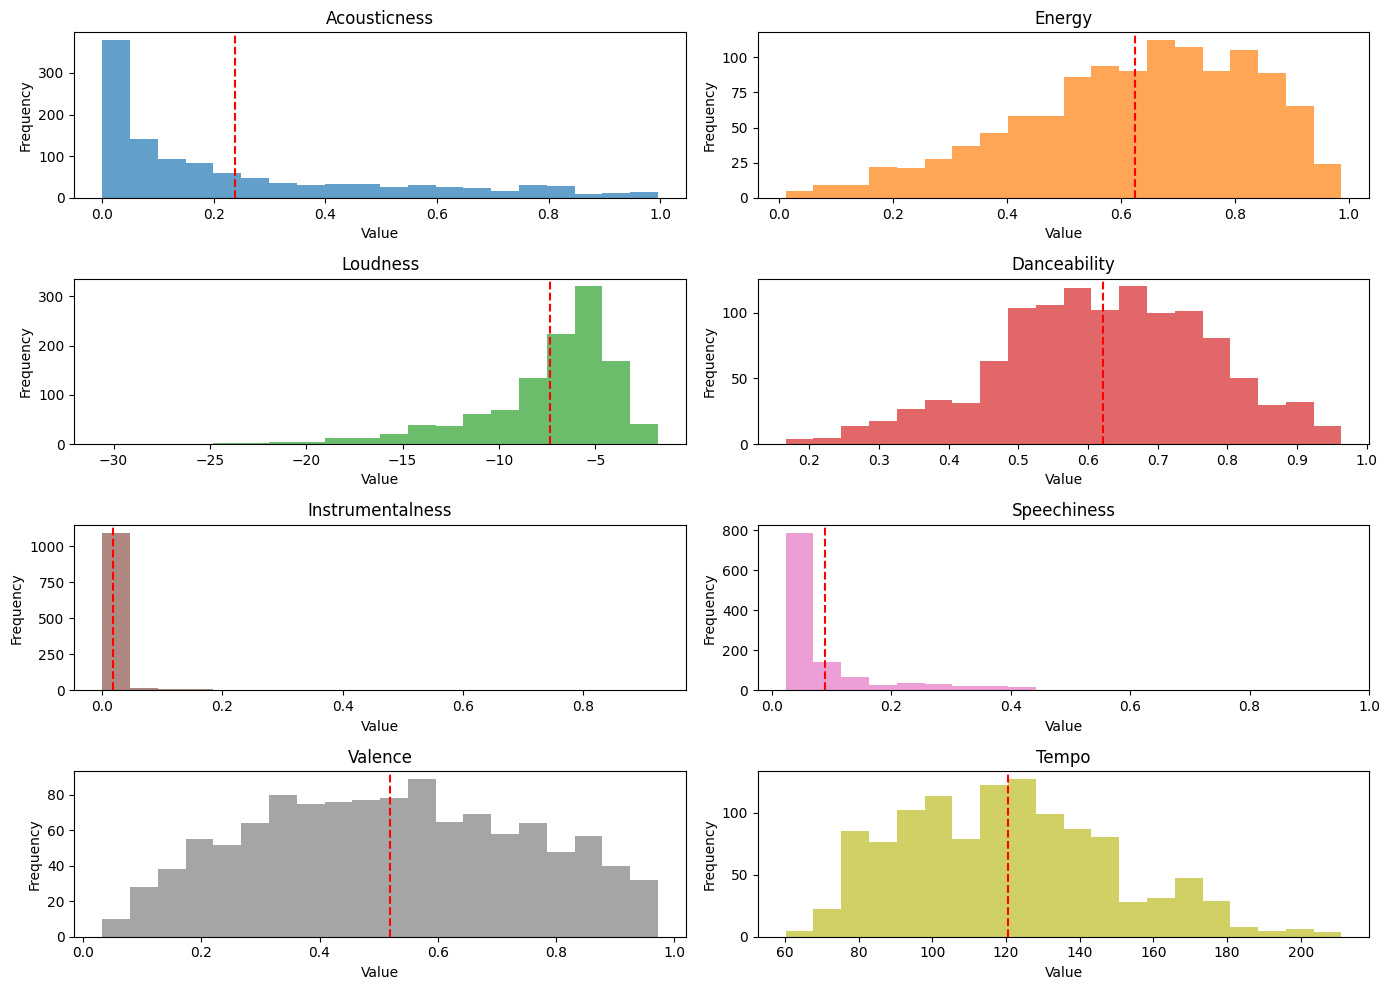

In [6]:
# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 10))  # Adjust the size as needed
axes = axes.ravel()  # Flatten the array of axes

# Generate a histogram for each feature
for i, feature in enumerate(features):
    # Select a color from the default colormap
    color = plt.cm.tab10(i / len(features))
    # Plot the histogram
    n, bins, patches = axes[i].hist(genre_df[feature], bins=20, color=color, alpha=0.7)
    # Calculate the mean and plot a vertical line
    mean_value = genre_df[feature].mean()
    axes[i].axvline(mean_value, color='red', linestyle='--')
    # Set titles and labels
    axes[i].set_title(feature.capitalize())
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlabel('Value')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

/Users/madhvimalhotra/anaconda3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/madhvimalhotra/anaconda3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/madhvimalhotra/anaconda3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/madhvimalhotra/anaconda3/envs/myenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

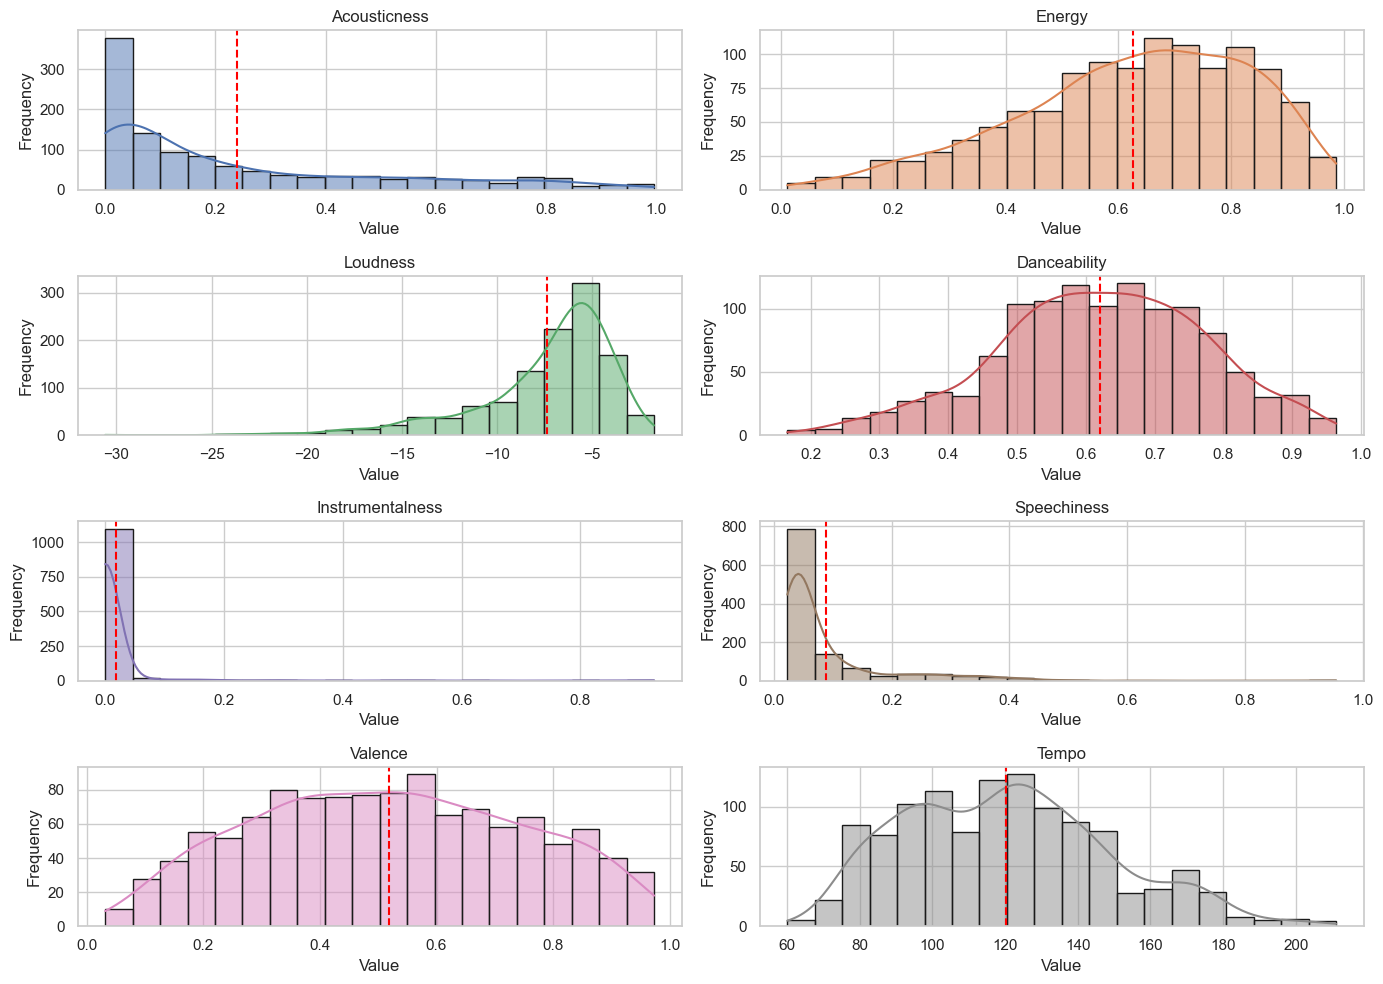

In [7]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 10))  # Adjust the size as needed
axes = axes.ravel()  # Flatten the array of axes

# Generate a histogram with a KDE plot for each feature
for i, feature in enumerate(features):
    # Select a color
    color = sns.color_palette()[i]
    # Plot the histogram with a KDE line
    sns.histplot(genre_df[feature], bins=20, ax=axes[i], color=color, kde=True, edgecolor="k")
    # Calculate the mean and plot a vertical line
    mean_value = genre_df[feature].mean()
    axes[i].axvline(mean_value, color='red', linestyle='--')
    # Set titles and labels
    axes[i].set_title(feature.capitalize())
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlabel('Value')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [8]:
# Get all Column Header Labels as List
for column_headers in genre_df.columns: 
    print(column_headers)
    

Artist
Track
Genre
Spotify_ID
danceability
energy
key
loudness
mode
speechiness
acousticness
instrumentalness
liveness
valence
tempo
type
id
uri
track_href
analysis_url
duration_ms
time_signature
Album_Name
Genres


# CLUSTERING

In [9]:
from sklearn.preprocessing import StandardScaler

# Selecting relevant features for clustering
feature_cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
features_df = genre_df[feature_cols]

# Standardizing the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df)


# Principal Component Analysis (PCA)
PCA is used to reduce the dimensionality of the data while retaining most of the variance.

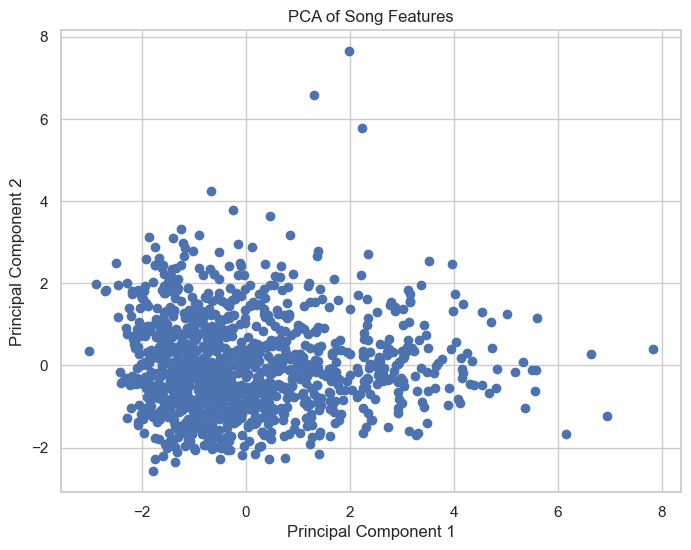

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Performing PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
principal_components = pca.fit_transform(scaled_features)

# Creating a DataFrame for PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Plotting the PCA results
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Song Features')
plt.show()


In [11]:
pca_df['Genre'] = genre_df['Genres']
 
pca_df['Track'] = genre_df['Track']  

pca_df['Track'] = genre_df['Artist'] 


In [12]:
# Convert genre labels to a numeric value for coloring
genre_labels = pca_df['Genre'].factorize()[0]

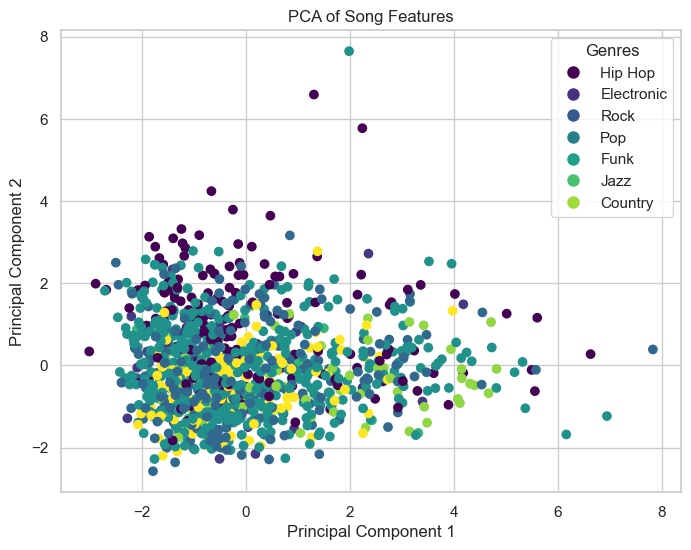

In [13]:
# Plotting the PCA results with color coding
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=genre_labels, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Song Features')

# Create a legend for the genres
genre_unique_values = genre_df['Genres'].unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', label=genre, 
                      markerfacecolor=plt.cm.viridis(i / len(genre_unique_values)), 
                      markersize=10) for i, genre in enumerate(genre_unique_values)]
plt.legend(handles=handles, title='Genres')

plt.show()



# Elbow method

The elbow method involves running the clustering algorithm (like K-Means) for a range of k values and plotting the total within-cluster sum of squares (inertia) against k. The "elbow" point, where the rate of decrease sharply changes, can suggest a good value for k.

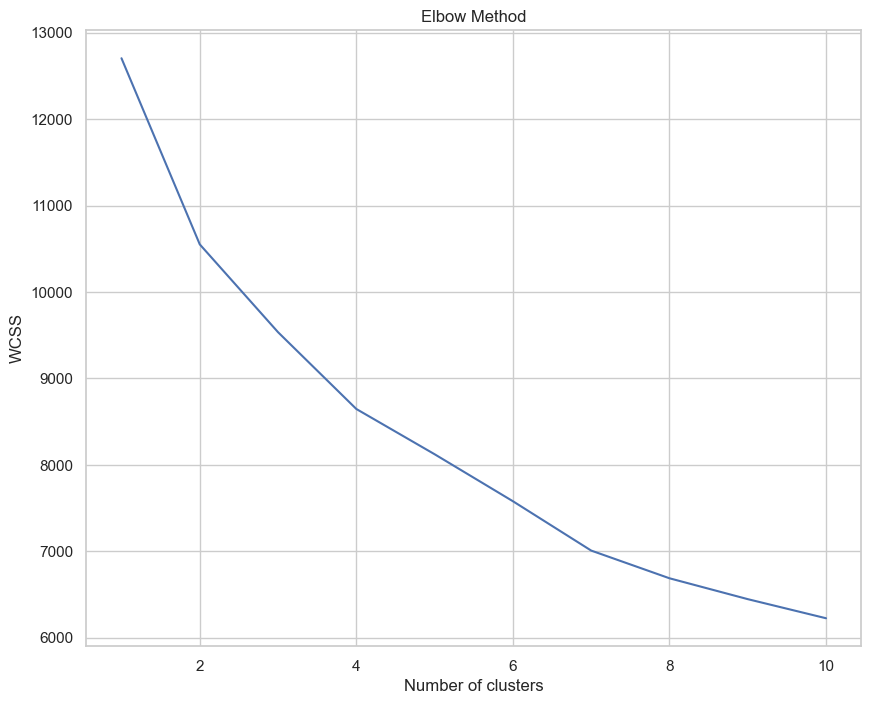

In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=22)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 8))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # within cluster sum of squares
plt.show()


# Cluster the Data:

Once you have determined the optimal number of clusters, you can run the clustering algorithm with that number of clusters.



In [15]:
optimal_k = 5  # Value found from the elbow plot
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=0)
cluster_labels = kmeans.fit_predict(scaled_features)


# Silhouette Score:

The silhouette score is a measure of how similar an object is to its own cluster compared to other clusters. The silhouette score ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.



In [16]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(scaled_features, cluster_labels)
print(f'The average silhouette_score is: {silhouette_avg}')


The average silhouette_score is: 0.16364999018777604


In [17]:
from sklearn.metrics import silhouette_score

# Calculate silhouette scores for a range of k values
k_values = range(2, 11)  # or any range you're interested in
silhouette_scores = {}
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(scaled_features)
    score = silhouette_score(scaled_features, labels)
    silhouette_scores[k] = score


/Users/madhvimalhotra/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/madhvimalhotra/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/madhvimalhotra/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/madhvimalhotra/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/cluster/

In [19]:
# Convert silhouette scores to a DataFrame for display
silhouette_scores_df = pd.DataFrame(list(silhouette_scores.items()), columns=['Number of Clusters', 'Silhouette Score'])

# Display the silhouette scores table
print(silhouette_scores_df)



   Number of Clusters  Silhouette Score
0                   2          0.220689
1                   3          0.155466
2                   4          0.125518
3                   5          0.163650
4                   6          0.137201
5                   7          0.140567
6                   8          0.135178
7                   9          0.124072
8                  10          0.125456


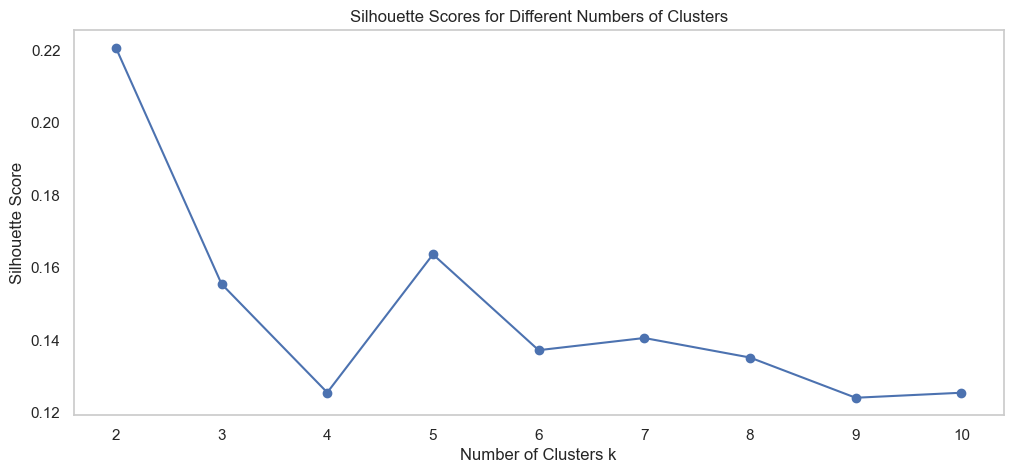

In [20]:
# Plot the silhouette scores
plt.figure(figsize=(12, 5))
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters k')
plt.ylabel('Silhouette Score')
plt.plot(silhouette_scores_df['Number of Clusters'], silhouette_scores_df['Silhouette Score'], marker='o')
plt.grid(False)
plt.show()

In [21]:
import warnings

# Suppress future warnings from scikit-learn
warnings.simplefilter(action='ignore', category=FutureWarning)


In [22]:
from ipywidgets import interact
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Calculate silhouette scores for a range of k values
k_values = range(2, 11)
silhouette_scores = {}
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(scaled_features)
    score = silhouette_score(scaled_features, labels)
    silhouette_scores[k] = score

# Function to update the PCA plot and display silhouette score
def update_pca_plot(k):
    # Specify n_init explicitly
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=10)

    cluster_labels = kmeans.fit_predict(scaled_features)
    pca_df['Cluster'] = cluster_labels
    
    # Plotting the PCA results
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_df['PC1'], pca_df['PC2'], c=cluster_labels, cmap='viridis')
    plt.title('Cluster Visualization on PCA-Reduced Data')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar()
    plt.show()
    
    # Print the silhouette score for the current k
    silhouette_avg = silhouette_scores[k]
    print(f'The average silhouette_score for k={k} is: {silhouette_avg}')

# Creating a slider interact widget
interact(update_pca_plot, k=(2,10))


interactive(children=(IntSlider(value=6, description='k', max=10, min=2), Output()), _dom_classes=('widget-int…

<function __main__.update_pca_plot(k)>

# Assign Clusters to Original DataFrame:

In [23]:
genre_df['Cluster'] = cluster_labels


### Cluster Composition:

In [24]:
for i in range(optimal_k):
    print(f"Cluster {i}:")
    print(genre_df[genre_df['Cluster'] == i]['Genres'].value_counts())
    print("\n")


Cluster 0:
Genres
Hip Hop       65
Pop           44
Rock          16
Electronic     4
Jazz           1
Country        1
Name: count, dtype: int64


Cluster 1:
Genres
Pop           102
Rock           48
Hip Hop        34
Jazz           30
Country        19
Funk            5
Electronic      1
Name: count, dtype: int64


Cluster 2:
Genres
Pop           219
Rock          119
Country        84
Hip Hop        48
Jazz           23
Electronic     17
Funk            4
Name: count, dtype: int64


Cluster 3:
Genres
Pop           115
Rock           51
Hip Hop        36
Jazz           16
Electronic     15
Country        12
Funk            7
Name: count, dtype: int64


Cluster 4:
Genres
Rock          8
Pop           5
Electronic    3
Jazz          2
Country       1
Name: count, dtype: int64




### Cluster Centers:

In [25]:
cluster_centers = kmeans.cluster_centers_
for i, centroid in enumerate(cluster_centers):
    print(f"Cluster {i} centroid in feature space:")
    print(pd.Series(centroid, index=feature_cols))
    print("\n")


Cluster 0 centroid in feature space:
danceability       -0.581610
energy             -0.371007
key                -0.360555
loudness           -1.207313
mode                0.106564
speechiness        -0.403045
acousticness        0.683598
instrumentalness    7.062672
liveness           -0.085776
valence            -0.198265
tempo               0.001885
dtype: float64


Cluster 1 centroid in feature space:
danceability       -0.044753
energy             -0.747372
key                 0.623057
loudness           -0.290458
mode                0.218262
speechiness        -0.349847
acousticness        1.103387
instrumentalness   -0.098511
liveness           -0.202777
valence            -0.452801
tempo              -0.632776
dtype: float64


Cluster 2 centroid in feature space:
danceability        0.209283
energy              0.767981
key                 0.675087
loudness            0.582215
mode                0.674285
speechiness        -0.169624
acousticness       -0.559380
instrumentalne

In [26]:
genre_df.to_csv("cluster.csv")

In [27]:
crosstab = pd.crosstab(genre_df['Genres'], genre_df['Cluster'])
print(crosstab)


Cluster      0    1    2    3  4
Genres                          
Country      1   19   84   12  1
Electronic   4    1   17   15  3
Funk         0    5    4    7  0
Hip Hop     65   34   48   36  0
Jazz         1   30   23   16  2
Pop         44  102  219  115  5
Rock        16   48  119   51  8


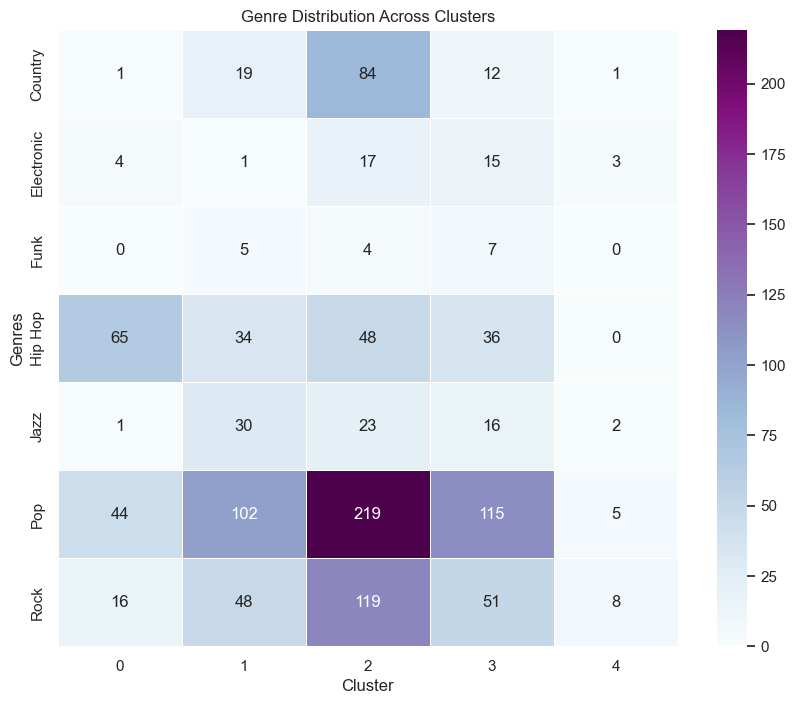

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt



plt.figure(figsize=(10, 8))
sns.heatmap(crosstab, annot=True, fmt="d", linewidths=.5, cmap='BuPu')
plt.title('Genre Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Genres')
plt.show()


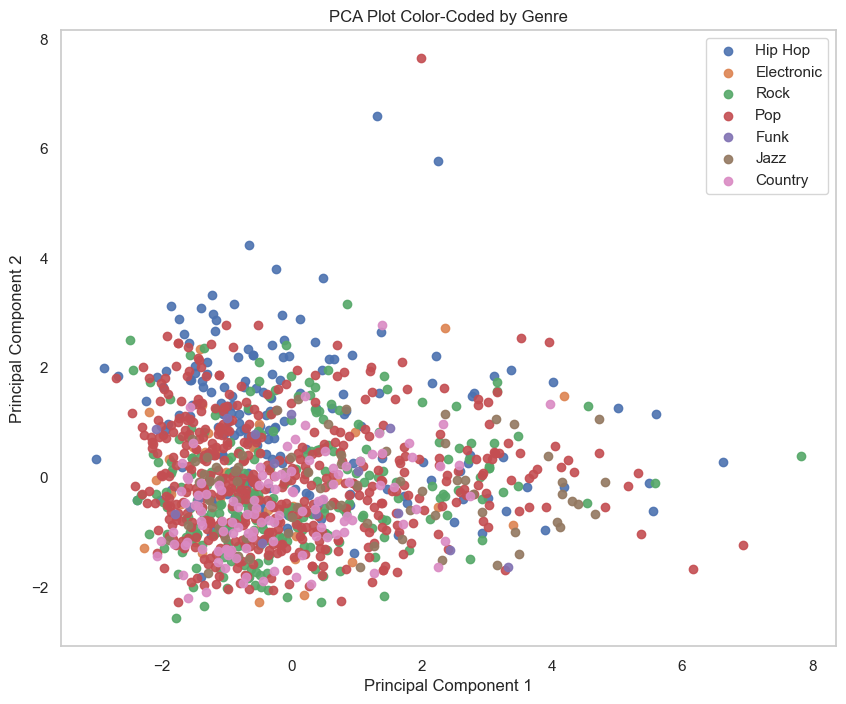

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
for genre in genre_df['Genres'].unique():
    cluster_subset = pca_df[genre_df['Genres'] == genre]
    next_color = plt.gca()._get_lines.get_next_color()
    # Increase the alpha value for less transparency
    plt.scatter(cluster_subset['PC1'], cluster_subset['PC2'], label=genre, alpha=0.9, color=next_color)

plt.legend()
plt.title('PCA Plot Color-Coded by Genre')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(False)  
plt.show()


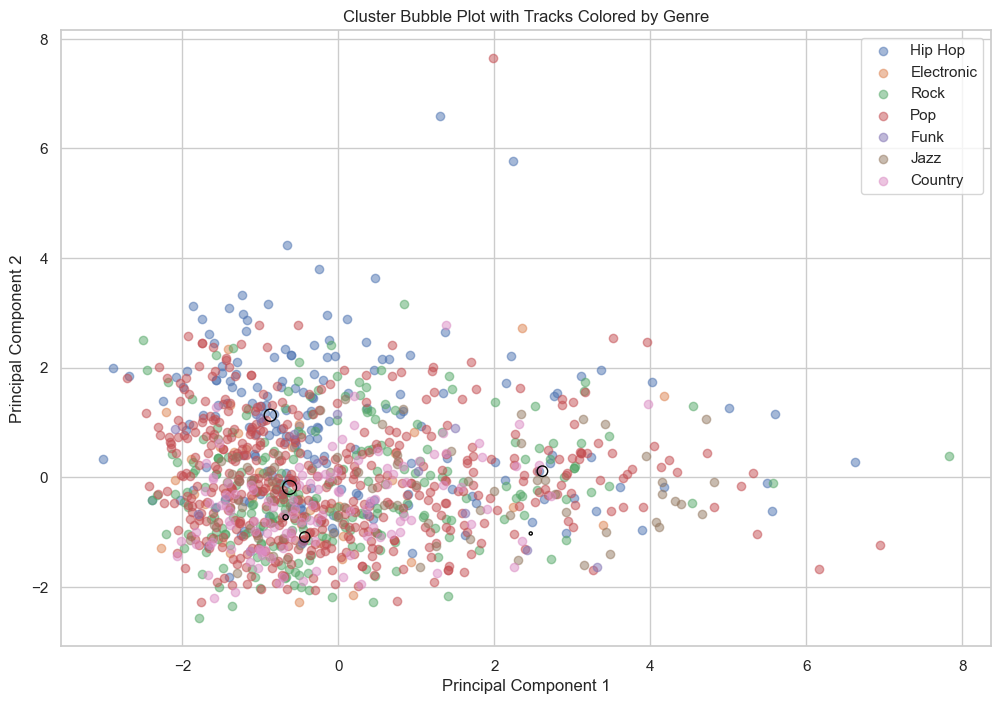

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate mean PCA components and cluster sizes
cluster_summary = pca_df.groupby('Cluster').agg({'PC1': 'mean', 'PC2': 'mean', 'Track': 'count'}).reset_index().rename(columns={'Track': 'Size'})

# Normalizing the cluster size for bubble size in the plot
cluster_summary['Size'] = (cluster_summary['Size'] / cluster_summary['Size'].max()) * 100  # Adjust 100 to scale the bubble sizes

# Create the bubble plot
plt.figure(figsize=(12, 8))
for genre in genre_df['Genres'].unique():
    genre_subset = pca_df[genre_df['Genres'] == genre]
    plt.scatter(genre_subset['PC1'], genre_subset['PC2'], label=genre, alpha=0.5)

# Add cluster bubbles
for _, row in cluster_summary.iterrows():
    plt.scatter(row['PC1'], row['PC2'], s=row['Size'], facecolors='none', edgecolors='black')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Bubble Plot with Tracks Colored by Genre')
plt.legend()
plt.show()
